# Part 1: Wrangling

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# toggle off row display limit
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
# toggle on row display limit
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

### Problem 1

In [4]:
sqlite_file = "lahman2014.sqlite"
conn = sql.connect(sqlite_file)

In [5]:
# sql code to retrieve the data of interest from the database
teams_query = """
                SELECT 
                    A.yearID, 
                    A.teamID, 
                    franchID,   
                    W, 
                    G, 
                    100*CAST(W AS float)/CAST(G AS float) AS winPercent,
                    payroll
                FROM 
                    Teams A
                INNER JOIN 
                    (SELECT yearID, teamID, SUM(salary) AS payroll FROM Salaries GROUP BY yearID, teamID) B 
                ON
                    A.yearID = B.yearID AND A.teamId = B.teamId
            """

# runs the sql code and stores the data in a dataframe
teams = pd.read_sql(teams_query, conn)

In [6]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0
...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0
854,2014,TBA,TBD,77,162,47.530864,72689100.0
855,2014,TEX,TEX,67,162,41.358025,112255059.0
856,2014,TOR,TOR,83,162,51.234568,109920100.0


I used the `read_sql()` function in Pandas to extract data from the SQLite database and put it into a Pandas database. In my SQL query, I used the `GROUP BY` statement to sum all of the salaries for each team/year combination in the Salaries table, and then used the `INNER JOIN` statement to combine the resulting table with selected data from the Teams table.

As a result of using `INNER JOIN`, team/year combinations that existed in one table but not the other (missing data) were not included in the final table. Therefore the final table does not have any data from before 1985, which is the earliest year of recorded data in the Salaries table.

For both of these tables, when the row exists, all variables in the row seem to exist.

# Part 2: Exploratory Data Analysis

## Payroll Distribution

### Problem 2

In [7]:
# organizes dataframe for analyzing payrolls
payrolls = teams.drop(teams.columns.difference(["yearID", "teamID", "payroll"]), 1).set_index("yearID")

# removes years before 1985-1989, we're only looking at 1990-2014
payrolls = payrolls.drop(index=[1985, 1986, 1987, 1988, 1989])

In [8]:
payrolls

,teamID,payroll
yearID,,
1990,ATL,14555501.0
1990,BAL,9680084.0
1990,BOS,20558333.0
1990,CAL,21720000.0
1990,CHA,9491500.0
...,...,...
2014,SLN,120693000.0
2014,TBA,72689100.0
2014,TEX,112255059.0


In [9]:
# "unmelts"; creates a seperate column for each team, index is still yearID
payrolls_team_cols = payrolls.pivot(columns="teamID")

In [10]:
payrolls_team_cols

payroll                                                    ...  \
teamID     ANA         ARI         ATL          BAL          BOS  ...   
yearID                                                            ...   
1990       NaN         NaN  14555501.0    9680084.0   20558333.0  ...   
1991       NaN         NaN  18403500.0   17519000.0   35167500.0  ...   
1992       NaN         NaN  34625333.0   23780667.0   43610584.0  ...   
1993       NaN         NaN  41641417.0   29096500.0   37120583.0  ...   
1994       NaN         NaN  49383513.0   38849769.0   37859084.0  ...   
...        ...         ...         ...          ...          ...  ...   
2010       NaN  60718166.0  84423666.0   81612500.0  162447333.0  ...   
2011       NaN  53639833.0  87002692.0   85304038.0  161762475.0  ...   
2012       NaN  73804833.0  82829942.0   77353999.0  173186617.0  ...   
2013       NaN  90132000.0  87871525.0   84393333.0  151530000.0  ...   
2014       NaN  97861500.0  97609000.0  103416000.0  139019929.0  ...   

                                                                        
teamID          SLN         TBA          TEX          TOR          WAS  
yearID                                                                  
1990     20523334.0         NaN   14874372.0   17756834.0          NaN  
1991     21860001.0         NaN   18224500.0   19902417.0          NaN  
1992     27583836.0         NaN   30128167.0   44788666.0          NaN  
1993     23367334.0         NaN   36376959.0   47279166.0          NaN  
1994     29275601.0         NaN   32973597.0   43433668.0          NaN  
...             ...         ...          ...          ...          ...  
2010     93540751.0  71923471.0   55250544.0   62234000.0   61400000.0  
2011    105433572.0  41053571.0   92299264.0   62567800.0   63856928.0  
2012    110300862.0  64173500.0  120510974.0   75009200.0   80855143.0  
2013     92260110.0  52955272.0  112522600.0  126288100.0  113703270.0  
2014    120693000.0  72689100.0  112255059.0  109920100.0  131983680.0  

[25 rows x 35 columns]

In [115]:
# removes "payroll" from column names for cleaner legend when plotted
payrolls_team_cols.columns = payrolls_team_cols.columns.droplevel()

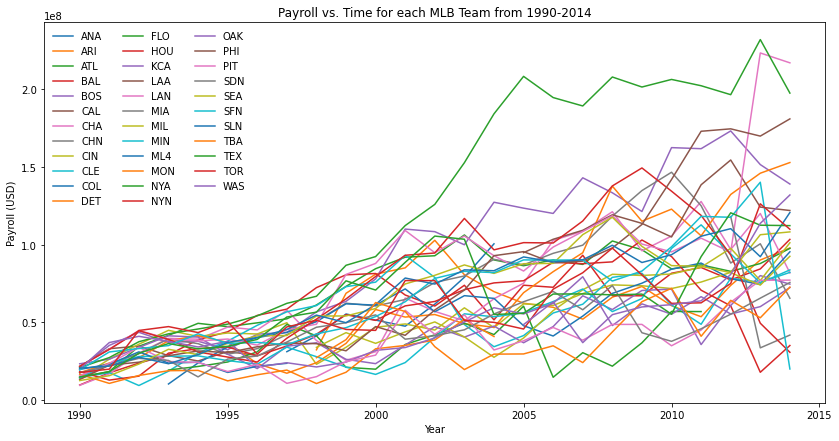

In [117]:
# plots the data
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
payrolls_team_cols.plot(ax=axes, title = "Payroll vs. Time for each MLB Team from 1990-2014")
plt.setp(axes, xlabel="Year", ylabel="Payroll (USD)")

# customizes legend
_ = axes.legend(frameon=False, loc='upper left', ncol=3)

To show the distribution of payrolls across teams conditioned on time I chose to plot lines showing each team's payroll and how it's changed over time from 1990-2014. I did this by first "unmelting" the table using `.pivot()` to give each team it's own column showing payroll for each year. From that I could easily plot the data using `.plot()`.

### Question 1

Looking at the graph, it's clear that the spread of payrolls increases a lot between 1990 and 2014—the lines are very close together (from the perspective the graph provides) in 1990, and very far apart in 2014. From this we can deduce that the variance/standiard deviation of the distribution of payrolls across teams increases over this time span.

The graph also shows a general upward trend in payrolls over time; if you imagine drawing a best fit line on the graph, you can see it would slope upward. Therefore, the graph shows that the average payroll of teams in the MLB increases from 1990-2014.

### Problem 3

In [13]:
# creates groupby object with the leage's total payrolls for each year
# object can be used to find mean, std deviation, etc of payrolls for each year
payrolls_by_year = payrolls.groupby("yearID")

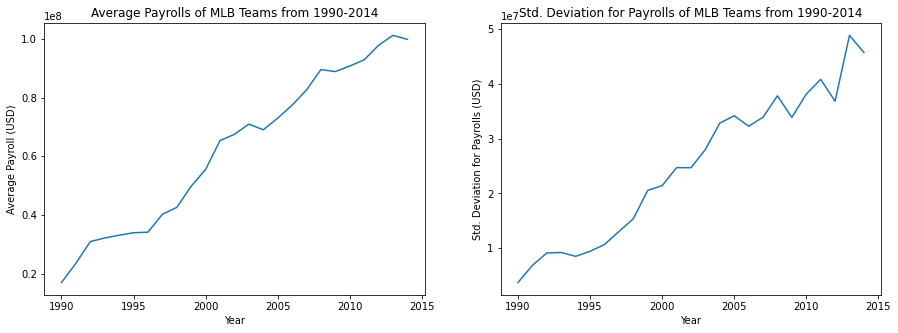

In [14]:
# plots the data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
payrolls_by_year.mean().plot(ax=axes[0], legend=False, ylabel="Average Payroll (USD)", 
                     title="Average Payrolls of MLB Teams from 1990-2014")
payrolls_by_year.std().plot(ax=axes[1], legend=False, ylabel="Std. Deviation for Payrolls (USD)",
                    title="Std. Deviation for Payrolls of MLB Teams from 1990-2014")
_ = plt.setp(axes, xlabel="Year")

## Correlation between payroll and winning percentage

### Problem 4

In [15]:
# puts each index from the teams dataframe in a bin based on its year
years = teams.iloc[:, 0].rename("bin")
bins = pd.cut(x=years, bins=[1990, 1995, 2000, 2005, 2010, 2015], labels=["A", "B", "C", "D", "E"], right=False)

# creates new dataframe with a bin column and select columns from the teams dataframe
binned = teams.drop(teams.columns.difference(["teamID", "winPercent", "payroll"]), 1).join(bins)

In [16]:
binned

,teamID,winPercent,payroll,bin
0,ATL,40.740741,14807000.0,NaN
1,BAL,51.552795,11560712.0,NaN
2,BOS,49.693252,10897560.0,NaN
3,CAL,55.555556,14427894.0,NaN
4,CHA,52.147239,9846178.0,NaN
...,...,...,...,...
853,SLN,55.555556,120693000.0,E
854,TBA,47.530864,72689100.0,E
855,TEX,41.358025,112255059.0,E
856,TOR,51.234568,109920100.0,E


In [17]:
means = binned.groupby(by=["bin", "teamID"]).mean()

In [18]:
means

# some bins have NaN because the teams don't exist in that time period, 
# for example the Diamonbacks (ARI) weren't founded until 1998, so they're NaN in bin A (1990-1994)

winPercent      payroll
bin teamID                         
A   ANA            NaN          NaN
    ARI            NaN          NaN
    ATL      56.497726   31721852.8
    BAL      50.444080   23785204.0
    BOS      49.514761   34863216.8
...                ...          ...
E   SLN      55.679012  104445659.0
    TBA      54.992047   60558982.8
    TEX      53.881694   98567688.2
    TOR      48.888889   87203840.0
    WAS      53.024308   90359804.2

[175 rows x 2 columns]

In [19]:
means = means.dropna()

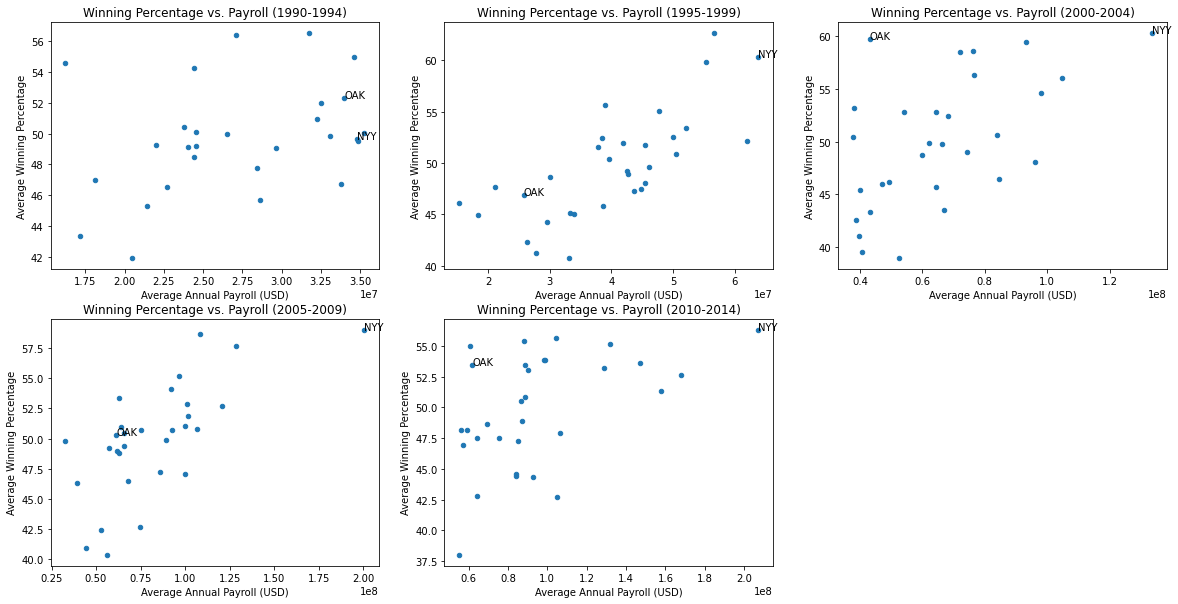

In [20]:
# creates 5 subplots
fig_p4, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig_p4.delaxes(axes[1][2])

# plots the data
means.loc["A"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][0], title="Winning Percentage vs. Payroll (1990-1994)")
# adds a label "OAK" for the point representing the Oakland A's
axes[0, 0].text(means.loc["A"].at["OAK", "payroll"], means.loc["A"].at["OAK", "winPercent"], "OAK")
# adds a label "NYY" for the point representing the New York Yankees
axes[0, 0].text(means.loc["A"].at["NYA", "payroll"], means.loc["A"].at["NYA", "winPercent"], "NYY")

means.loc["B"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][1], title="Winning Percentage vs. Payroll (1995-1999)")
axes[0, 1].text(means.loc["B"].at["OAK", "payroll"], means.loc["B"].at["OAK", "winPercent"], "OAK")
axes[0, 1].text(means.loc["B"].at["NYA", "payroll"], means.loc["B"].at["NYA", "winPercent"], "NYY")

means.loc["C"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][2], title="Winning Percentage vs. Payroll (2000-2004)")
axes[0, 2].text(means.loc["C"].at["OAK", "payroll"], means.loc["C"].at["OAK", "winPercent"], "OAK")
axes[0, 2].text(means.loc["C"].at["NYA", "payroll"], means.loc["C"].at["NYA", "winPercent"], "NYY")

means.loc["D"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][0], title="Winning Percentage vs. Payroll (2005-2009)")
axes[1, 0].text(means.loc["D"].at["OAK", "payroll"], means.loc["D"].at["OAK", "winPercent"], "OAK")
axes[1, 0].text(means.loc["D"].at["NYA", "payroll"], means.loc["D"].at["NYA", "winPercent"], "NYY")

means.loc["E"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][1], title="Winning Percentage vs. Payroll (2010-2014)")
axes[1, 1].text(means.loc["E"].at["OAK", "payroll"], means.loc["E"].at["OAK", "winPercent"], "OAK")
axes[1, 1].text(means.loc["E"].at["NYA", "payroll"], means.loc["E"].at["NYA", "winPercent"], "NYY")

plt.setp(axes, xlabel="Average Annual Payroll (USD)")
# added "_ =" for clean output
_ = plt.setp(axes, ylabel="Average Winning Percentage")

To create the 5 plots, I first used the `groupby()` function in Pandas to group the data by chunks of time and team, and take the mean payroll and winning percentage for teams in each. I chose the 5 groups that I did (between 1990-2014) because each time chunk is equal, and we can compare results with results in problems 2 and 3. I then plotted the values for teams within each time chunk on 5 different plots. I chose to label two teams on the plots to make analysis easier. The Oakland A's are labeled "OAK", and the New York Yankees are labeled "NYY".

I chose these teams becase the A's are known having used analytics to win while spending less than other teams, while the Yankees are known for spending a lot of money (also becase I am a Yankees fan). Both of these teams don't rename or move in 1990-2014, so they are in all 5 plots.

### Question 2

Before analyzing what these plots show, it's important to notice that the x-axis is not consistent for all of them. There seems to a general trend of teams spending more money over time, which is consistent with what I found in part 2 of this project. In 1990-1994 the highest spending teams were around a average annual payroll of \\$35 million—in 1995-1999 there were many teams above \\$40 million, and the highest spending teams were around \\$6 million.

In general, it's easy to see a slight trend upward in most of these graphs, meaning teams that spend more money tend to have a higher winning percentage. It is not until 2010-2014 that you begin to see many teams be near the top in winning percentage that are on the lower end of the league in terms of average annual payroll.

The first thing I noticed when looking at these graphs is the Yankees' increase in spending between 1995-1999 and 2005-2009. In the former their average payroll appears to be around \\$65 million a year, whereas in the latter it is around \\$200 million, and by then the Yankees have really become an outlier in spending. In the case of the Yankees, this does seem to translate into winning games, because their winning percentage is at or is very near the highest in the league for all three time chunks following their initial spending increase. You could say that the Yankees were particularly good at "paying for wins" from 1995 to 2014.

The first graph shows that the A's in 1990-1994 had one of the highest average annual payrolls in the MLB. However, in 1995-1999 their spending had not increased by nearly as much as other teams in the league, and they had one of the lowest average payrolls; their success seemed to reflect that, their winning percentage was below 50\% and was pretty low compared to most other teams over that span. In 2000-2004 their average payroll was still one of the lowest in the league but their winning percentage was one of the best—almost tied with the Yankees! Something must have happened around the turn of the millennium that helped the A's win games with much less money than other teams.

They remained low spenders relative to other teams in the next two time chunks, but always had a winning record on average (winning percent over 50\%). In 2005 to 2009 their winning percentage was only mediocre, but in 2010-2014 they were back to being near the top of the league.

# Part 3: Data transformations

## Standardizing Across Years

### Problem 5

In [21]:
teams_temp = teams[["yearID", "payroll"]]

# adds columns for the mean and standard deviation payrolls in the row's yearID to each row
teams_temp = teams_temp.join(other=teams.groupby("yearID").mean()["payroll"], on="yearID", rsuffix="Mean")
teams_temp = teams_temp.join(other=teams.groupby("yearID").std()["payroll"], on="yearID", rsuffix="Std")

In [22]:
# adds a column that contains the row's payroll, mean, and std as a tuple
teams_temp["asTuple"]= list(zip(teams_temp.payroll, teams_temp.payrollMean, teams_temp.payrollStd))

In [23]:
teams_temp

,yearID,payroll,payrollMean,payrollStd,asTuple
0,1985,14807000.0,1.007557e+07,2.470845e+06,"(14807000.0, 10075565.23076923, 2470845.431692..."
1,1985,11560712.0,1.007557e+07,2.470845e+06,"(11560712.0, 10075565.23076923, 2470845.431692..."
2,1985,10897560.0,1.007557e+07,2.470845e+06,"(10897560.0, 10075565.23076923, 2470845.431692..."
3,1985,14427894.0,1.007557e+07,2.470845e+06,"(14427894.0, 10075565.23076923, 2470845.431692..."
4,1985,9846178.0,1.007557e+07,2.470845e+06,"(9846178.0, 10075565.23076923, 2470845.4316927..."
...,...,...,...,...,...
853,2014,120693000.0,9.980002e+07,4.570505e+07,"(120693000.0, 99800015.53333333, 45705053.4666..."
854,2014,72689100.0,9.980002e+07,4.570505e+07,"(72689100.0, 99800015.53333333, 45705053.46662..."
855,2014,112255059.0,9.980002e+07,4.570505e+07,"(112255059.0, 99800015.53333333, 45705053.4666..."
856,2014,109920100.0,9.980002e+07,4.570505e+07,"(109920100.0, 99800015.53333333, 45705053.4666..."


In [24]:
# function to get standardized payroll
def standardize(tup):
    payroll, avg, std = tup
    return (payroll - avg) / std

In [25]:
# transforms the column of tuples and adds the result to the teams dataframe
teams["standardizedPayroll"] = teams_temp.asTuple.transform(standardize)

In [26]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll,standardizedPayroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0,1.914905
1,1985,BAL,BAL,83,161,51.552795,11560712.0,0.601068
2,1985,BOS,BOS,81,163,49.693252,10897560.0,0.332678
3,1985,CAL,ANA,90,162,55.555556,14427894.0,1.761474
4,1985,CHA,CHW,85,163,52.147239,9846178.0,-0.092838
...,...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0,0.457126
854,2014,TBA,TBD,77,162,47.530864,72689100.0,-0.593171
855,2014,TEX,TEX,67,162,41.358025,112255059.0,0.272509
856,2014,TOR,TOR,83,162,51.234568,109920100.0,0.221422


To transform the data using `.transform()`, I wanted to input the payroll, the average payroll, and the standard deviation as a tuple. To get the data in that format, I first made two new columns in a temporary dataframe for the average and standard deviation. Then I used `zip()` to combine them into a new column of tuples.

Using a function I defined that takes in a tuple and gives the standardized payroll, I transformed the column of tulples and added the result to my dataset.

### Problem 6

In [27]:
# can reuse the "bins" series from before

# creates new dataframe with a bin column and select columns from the teams dataframe
binned = teams.drop(teams.columns.difference(["teamID", "winPercent", "standardizedPayroll"]), 1).join(bins)

means = binned.groupby(by=["bin", "teamID"]).mean()
means = means.dropna()

In [28]:
means

winPercent  standardizedPayroll
bin teamID                                 
A   ATL      56.497726             0.381441
    BAL      50.444080            -0.658533
    BOS      49.514761             1.014231
    CAL      45.704777             0.338304
    CHA      56.426308            -0.309019
...                ...                  ...
E   SLN      55.679012             0.199817
    TBA      54.992047            -0.850728
    TEX      53.881694             0.036064
    TOR      48.888889            -0.274002
    WAS      53.024308            -0.195302

[151 rows x 2 columns]

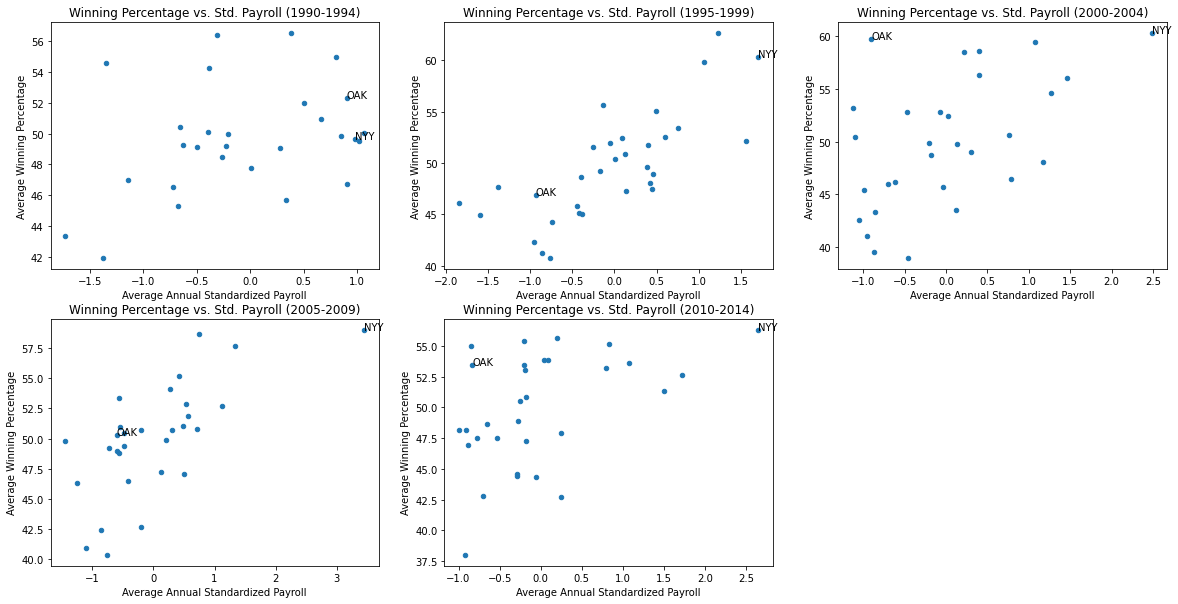

In [29]:
# creates 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.delaxes(axes[1][2])

# plots the data
means.loc["A"].plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes[0][0], title="Winning Percentage vs. Std. Payroll (1990-1994)")
# adds a label "OAK" for the point representing the Oakland A's
axes[0, 0].text(means.loc["A"].at["OAK", "standardizedPayroll"], means.loc["A"].at["OAK", "winPercent"], "OAK")
# adds a label "NYY" for the point representing the New York Yankees
axes[0, 0].text(means.loc["A"].at["NYA", "standardizedPayroll"], means.loc["A"].at["NYA", "winPercent"], "NYY")

means.loc["B"].plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes[0][1], title="Winning Percentage vs. Std. Payroll (1995-1999)")
axes[0, 1].text(means.loc["B"].at["OAK", "standardizedPayroll"], means.loc["B"].at["OAK", "winPercent"], "OAK")
axes[0, 1].text(means.loc["B"].at["NYA", "standardizedPayroll"], means.loc["B"].at["NYA", "winPercent"], "NYY")

means.loc["C"].plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes[0][2], title="Winning Percentage vs. Std. Payroll (2000-2004)")
axes[0, 2].text(means.loc["C"].at["OAK", "standardizedPayroll"], means.loc["C"].at["OAK", "winPercent"], "OAK")
axes[0, 2].text(means.loc["C"].at["NYA", "standardizedPayroll"], means.loc["C"].at["NYA", "winPercent"], "NYY")

means.loc["D"].plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes[1][0], title="Winning Percentage vs. Std. Payroll (2005-2009)")
axes[1, 0].text(means.loc["D"].at["OAK", "standardizedPayroll"], means.loc["D"].at["OAK", "winPercent"], "OAK")
axes[1, 0].text(means.loc["D"].at["NYA", "standardizedPayroll"], means.loc["D"].at["NYA", "winPercent"], "NYY")

means.loc["E"].plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes[1][1], title="Winning Percentage vs. Std. Payroll (2010-2014)")
axes[1, 1].text(means.loc["E"].at["OAK", "standardizedPayroll"], means.loc["E"].at["OAK", "winPercent"], "OAK")
axes[1, 1].text(means.loc["E"].at["NYA", "standardizedPayroll"], means.loc["E"].at["NYA", "winPercent"], "NYY")

plt.setp(axes, xlabel="Average Annual Standardized Payroll")
# added "_ =" for clean output
_ = plt.setp(axes, ylabel="Average Winning Percentage")

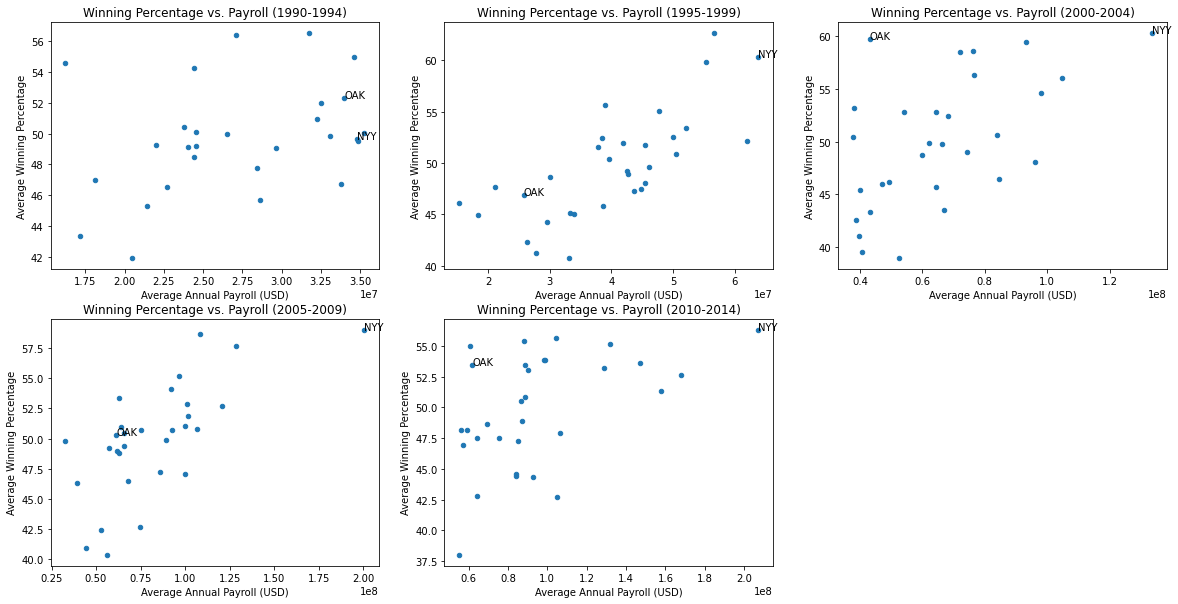

In [30]:
# figure from problem 4 for comparison
fig_p4

I used the same code to get the same graphs from problem 4, only this time I used standardized payroll instead of payroll for the x-axis.

### Question 3

The plots in problem 4 and problem 6 are basically the same, except in problem 6 instead of plotting winning percentage against payroll, we're plotting it against the standardized payroll: the number of standard deviations that the given team is from the mean payroll of that year. Because of this, the plots in problem 6 look pretty similar to the ones in problem 4—a team with a high payroll is also going to have a high standardized payroll.

However, 

<AxesSubplot:>

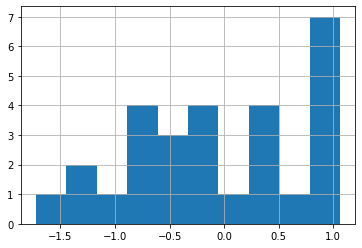

In [31]:
means.loc["A"].standardizedPayroll.hist()

## Expected Wins

### Problem 7

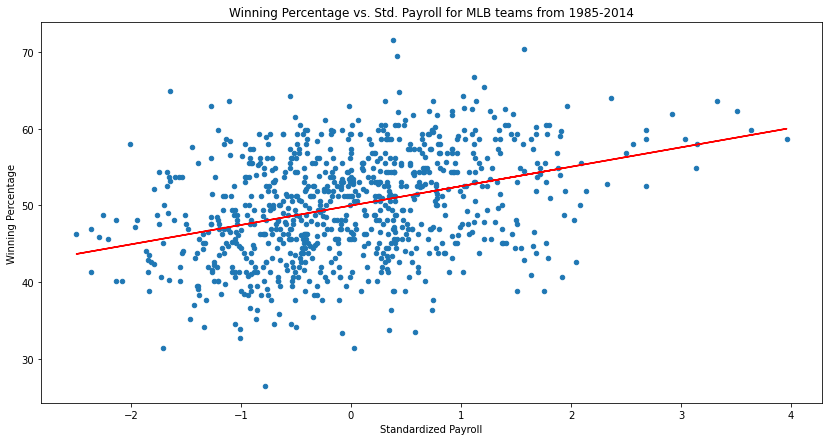

In [32]:
fig, axes = plt.subplots(figsize=(14, 7))

# plots data
teams.plot.scatter(x="standardizedPayroll", y="winPercent", ax=axes, title="Winning Percentage vs. Std. Payroll for MLB teams from 1985-2014")
plt.setp(axes, xlabel="Standardized Payroll", ylabel="Winning Percentage")

# calculates polynomial for best fit line
fit = np.polyfit(x=teams.standardizedPayroll, y=teams.winPercent, deg=1)
fun = np.poly1d(fit)

# plots best fit line
x = teams.standardizedPayroll
y = fun(x)
_ = axes.plot(x, y, color="r")

The code in this section is pretty straightforward. The x and y coordinates for each team was already in my dataset under the standardized payroll and winning percentage columns. I used that to plot the data, and then used that data along with `numpy.polyfit()` to get the best fit line.

## Spending Efficiency

### Problem 8

In [33]:
# calculates a series for all expected win percents based on equation given in project description
ex_win_pcts = teams.standardizedPayroll.transform(lambda x: 50 + 2.5*x)

In [38]:
# creates a series with win percent and expected win percent in a tuple for each team 
tups = pd.Series(list(zip(teams.winPercent, ex_win_pcts)))

In [40]:
def get_efficiency(tup):
    win_pct, ex_win_pct = tup
    return win_pct - ex_win_pct

In [43]:
# adds column for efficiency to teams dataframe
teams["efficiency"] = tups.transform(get_efficiency)

In [69]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll,standardizedPayroll,efficiency
0,1985,ATL,ATL,66,162,40.740741,14807000.0,1.914905,-14.046522
1,1985,BAL,BAL,83,161,51.552795,11560712.0,0.601068,0.050124
2,1985,BOS,BOS,81,163,49.693252,10897560.0,0.332678,-1.138442
3,1985,CAL,ANA,90,162,55.555556,14427894.0,1.761474,1.151872
4,1985,CHA,CHW,85,163,52.147239,9846178.0,-0.092838,2.379333
...,...,...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0,0.457126,4.412740
854,2014,TBA,TBD,77,162,47.530864,72689100.0,-0.593171,-0.986208
855,2014,TEX,TEX,67,162,41.358025,112255059.0,0.272509,-9.323248
856,2014,TOR,TOR,83,162,51.234568,109920100.0,0.221422,0.681014


In [66]:
# creates dataframe with yearID as the index and each team's efficiency as a column
efficiencies = teams[["yearID", "teamID", "efficiency"]].set_index("yearID").pivot(columns="teamID")

In [67]:
efficiencies

efficiency                                              ...             \
teamID        ANA        ARI        ATL        BAL        BOS  ...        SLN   
yearID                                                         ...              
1985          NaN        NaN -14.046522   0.050124  -1.138442  ...  10.583612   
1986          NaN        NaN  -9.407444  -5.848780   6.996707  ...   0.610193   
1987          NaN        NaN -11.080202 -10.861509  -1.631301  ...   7.814129   
1988          NaN        NaN -17.115473 -17.918590   3.210569  ...  -4.063980   
1989          NaN        NaN  -8.954621   7.606103  -1.312307  ...   0.874902   
...           ...        ...        ...        ...        ...  ...        ...   
2010          NaN  -7.909220   6.585297  -8.662415   0.233085  ...   2.900879   
2011          NaN  10.424539   5.294426  -6.947199   1.332185  ...   4.782698   
2012          NaN   1.626481   9.038345   8.792891 -12.529190  ...   3.469300   
2013          NaN   0.564140   9.939131   3.327083   7.297245  ...  10.331729   
2014          NaN -10.387793  -1.114723   9.061470  -8.318112  ...   4.412740   

                                                   
teamID        TBA       TEX        TOR        WAS  
yearID                                             
1985          NaN -9.063310  12.768601        NaN  
1986          NaN  7.702377   2.156328        NaN  
1987          NaN  2.535140   9.261966        NaN  
1988          NaN -1.934376   3.197726        NaN  
1989          NaN  2.602103   3.246073        NaN  
...           ...       ...        ...        ...  
2010    10.491616  7.881505   4.337034  -5.484807  
2011     9.343678  9.290964   1.852951   1.463425  
2012     7.836027  5.862428  -3.393570  11.641575  
2013     8.909222  5.246013  -5.607958   2.443765  
2014    -0.986208 -9.323248   0.681014   7.498860  

[30 rows x 35 columns]

In [68]:
# removes "efficiency" from column names for cleaner legend when plotted
efficiencies.columns = efficiencies.columns.droplevel()

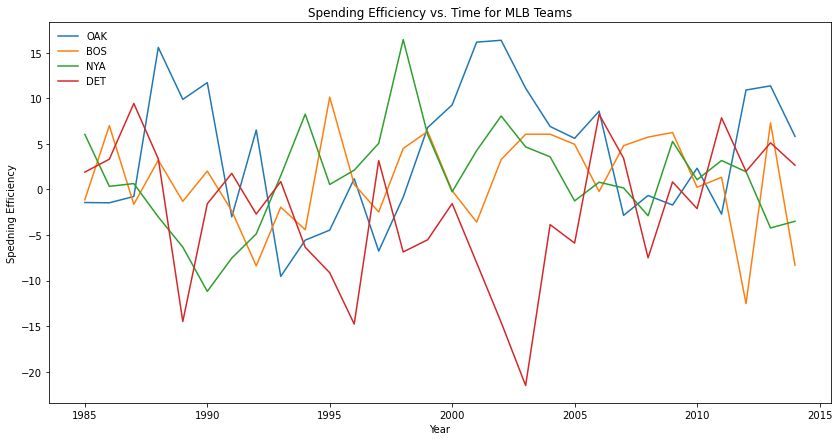

In [124]:
fig, axes = plt.subplots(figsize=(14, 7))

# plots the data
efficiencies[["OAK", "BOS", "NYA", "DET"]].plot(ax=axes, title="Spending Efficiency vs. Time for MLB Teams")
plt.setp(axes, xlabel="Year", ylabel="Spedning Efficiency")

# customizes legend
_ = axes.legend(frameon=False, loc='upper left', ncol=1)

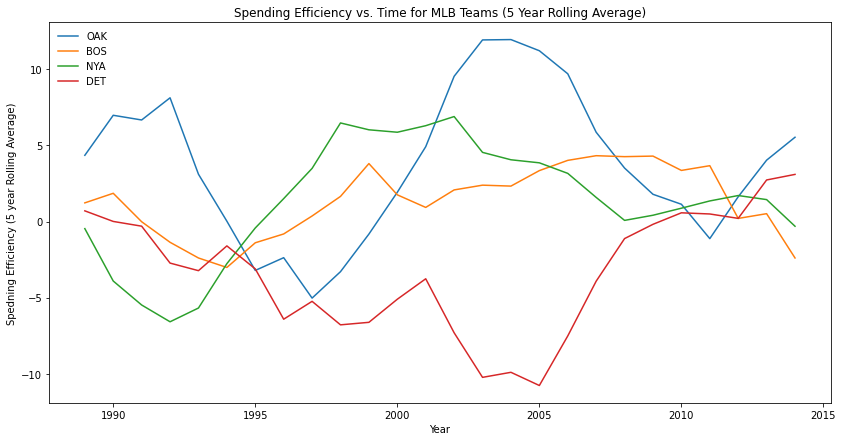

In [127]:
fig, axes = plt.subplots(figsize=(14, 7))

# plots the rolling average of the data
efficiencies[["OAK", "BOS", "NYA", "DET"]].rolling(5).mean().plot(ax=axes, title="Spending Efficiency vs. Time for MLB Teams (5 Year Rolling Average)")
plt.setp(axes, xlabel="Year", ylabel="Spedning Efficiency (5 year Rolling Average)")

# customizes legend
_ = axes.legend(frameon=False, loc='upper left', ncol=1)

To get efficiency for each team, I made a series of tuples that contained win percent and expected win percent, and then used `.transform()` to subtract expected win percent from win percent. I then used `.pivot()` to get a dataframe with columns for the efficiency of each team where rows are each year; this way the data would be easier to plot.

I decided to plot the Oakland A's (OAK) and the New York Yankees (NYA) to be able to compare with the graphs in problems 4 and 6. I also wanted to plot other teams for context; I decided on the the Boston Red Sox (BOS), a team whose spending efficiency is pretty middle-of-the-road and stays around the 0 mark, and the Detroit Tigers (DET), who seem to have poor spending efficiency in general.

After seeing my initial plot, I decided to also look at the 5 year rolling average to make the trends easier to see.

### Question 4

In [ ]:
# TODO: Questions 3 and 4